In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#A function that takes in two arrays and regresses x onto y
def regress(x,y):
    #Creating a fit of the pst data using linear trends
    t = x

    E = np.ones((t.size,2))*np.nan

    E[:,0] = t
    E[:,1] = 1

    EtE_inv = np.linalg.inv((np.dot(E.T,E)))
    xhat = np.dot(np.dot(EtE_inv,E.T),y)
    yhat = np.dot(E,xhat)
    
    P = np.var(yhat) * np.linalg.inv(np.dot(np.transpose(E),E))
    se = np.sqrt(np.diag(P))
    
    rho2 = np.corrcoef(yhat,y)[0,1]**2
    
    return yhat,rho2,xhat[0],xhat[1]

In [3]:
#reading in dataset
dset = pd.read_pickle('LIS-PR-MAM-v2.pkl')

In [4]:
#Since LIS accumulates over ~90 seconds, multiply by 2/3 to get ~1 minute flash rate
# (easier to compare with GLM)
lis_1min = dset['LISFlashes'].values*(2/3)

In [5]:
pr_vars = ['PrecipRateMAX','PrecipRate90PERCENTILE','PrecipRate75PERCENTILE','PrecipRateMEAN','PrecipRateMEDIAN','PrecipRate25PERCENTILE','PrecipRate10PERCENTILE','PrecipRateMIN']

# Rainfall Rate Regressions-Plots

/var/folders/52/nq3gfrwd7nz1_tyq4yszmgmc0000gn/T/ipykernel_12252/184383315.py:5: RuntimeWarning: divide by zero encountered in log10
  rainfall_mean = slope_mean * np.log10(flash_values) + intercept_mean
/var/folders/52/nq3gfrwd7nz1_tyq4yszmgmc0000gn/T/ipykernel_12252/184383315.py:6: RuntimeWarning: divide by zero encountered in log10
  rainfall_90 = slope_90 * np.log10(flash_values) + intercept_90


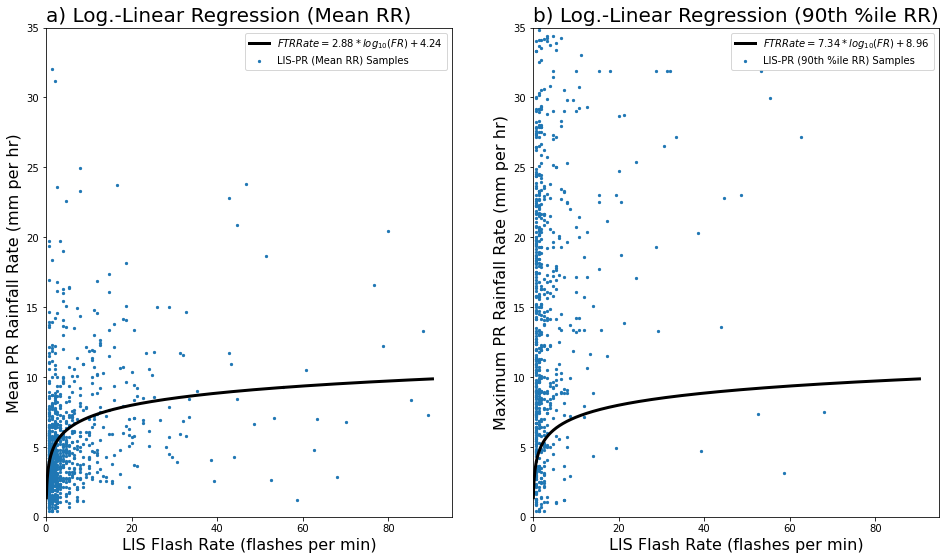

In [6]:
yhat_mean,rho2_mean,slope_mean,intercept_mean = regress(np.log10(lis_1min),dset['PrecipRateMEAN'].values)
yhat_90,rho2_90,slope_90,intercept_90 = regress(np.log10(lis_1min),dset['PrecipRateMEAN'].values)

flash_values = np.arange(0,np.max(lis_1min)+1,.1)
rainfall_mean = slope_mean * np.log10(flash_values) + intercept_mean
rainfall_90 = slope_90 * np.log10(flash_values) + intercept_90



fig = plt.figure(figsize=(16,9))
fig.patch.set_facecolor('White')

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(lis_1min, dset['PrecipRateMEAN'],s=5, label='LIS-PR (Mean RR) Samples')
ax1.plot(flash_values, rainfall_mean, color='k', label='$FTR Rate = 2.88*log_{10}(FR) + 4.24$', linewidth=3)
ax1.set_xlim(0,)
ax1.set_ylim(0,35)
ax1.legend()
ax1.set_title('a) Log.-Linear Regression (Mean RR)', fontsize=20, loc='left')
ax1.set_xlabel('LIS Flash Rate (flashes per min)', fontsize=16)
ax1.set_ylabel('Mean PR Rainfall Rate (mm per hr)', fontsize=16)

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(lis_1min, dset['PrecipRateMAX'],s=5, label='LIS-PR (90th %ile RR) Samples')
ax2.plot(flash_values, rainfall_mean, color='k', label='$FTR Rate = 7.34*log_{10}(FR) + 8.96$', linewidth=3)

ax2.set_xlim(0,)
ax2.set_ylim(0,35)
ax2.legend()
ax2.set_title('b) Log.-Linear Regression (90th %ile RR)', fontsize=20, loc='left')
ax2.set_xlabel('LIS Flash Rate (flashes per min)', fontsize=16)
ax2.set_ylabel('Maximum PR Rainfall Rate (mm per hr)', fontsize=16)

plt.savefig('regression-mean-max.png')

# Binned Regressions

In [7]:
drr = 3
bin_vals = np.arange(0,65,drr)

ltg_mean = np.empty(shape=0)

for val in bin_vals:
    selects = dset.loc[((dset['PrecipRateMEAN'] >= val) & (dset['PrecipRateMEAN'] < (val+drr))),'LISFlashes'].values
    #print (selects) 
    if len(selects)>5:
        bin_mean = np.mean(selects*(2/3))
    else:
        bin_mean = np.nan
    
    ltg_mean = np.append(ltg_mean, bin_mean)

    
tf = ~np.isnan(ltg_mean)
bin_vals = bin_vals[tf]
ltg_mean = ltg_mean[tf]

In [8]:
yhat_bins, rho2_bins, slope_bins, yintercept_bins = regress(np.log10(ltg_mean),bin_vals+(drr/2))

/var/folders/52/nq3gfrwd7nz1_tyq4yszmgmc0000gn/T/ipykernel_12252/1755883409.py:1: RuntimeWarning: divide by zero encountered in log10
  rainfall_binned = slope_bins * np.log10(flash_values) + yintercept_bins


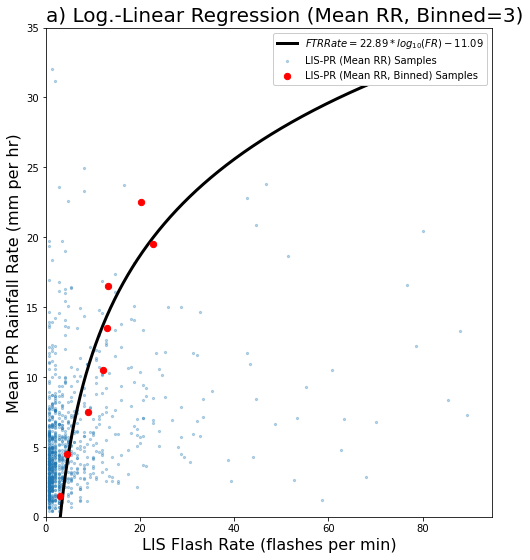

In [9]:
rainfall_binned = slope_bins * np.log10(flash_values) + yintercept_bins

fig = plt.figure(figsize=(8,9))
fig.patch.set_facecolor('White')

ax1 = plt.subplot(1, 1, 1)
ax1.scatter(lis_1min, dset['PrecipRateMEAN'],s=5, label='LIS-PR (Mean RR) Samples', alpha=0.3)
ax1.scatter(ltg_mean, bin_vals+(drr/2), s=40, label='LIS-PR (Mean RR, Binned) Samples', color='r', zorder=10)
ax1.plot(flash_values, rainfall_binned, color='k', label='$FTR Rate = 22.89*log_{10}(FR) -11.09 $', linewidth=3)
ax1.set_xlim(0,)
ax1.set_ylim(0,35)
ax1.legend(loc='upper right', facecolor='white').get_frame().set_alpha(None)
ax1.set_title('a) Log.-Linear Regression (Mean RR, Binned='+str(drr)+')', fontsize=20, loc='left')
ax1.set_xlabel('LIS Flash Rate (flashes per min)', fontsize=16)
ax1.set_ylabel('Mean PR Rainfall Rate (mm per hr)', fontsize=16)
plt.savefig('regression-mean-binned3.png')